In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, Activation, LSTM, GRU, SimpleRNN, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [ ]:
def get_split_datasets(data_dir, mark_up_csv, test_size=0.15, random_state=11):
    mark_up = pd.read_csv(mark_up_csv)
    video_names = list(mark_up["video_name"].values)

    label_dir = f"{data_dir}/labels"
    video_label_names = [n.split(".")[0] for n in video_names]
    video_labels = np.array([np.load(f"{label_dir}/{l}.npy") for l in video_label_names])[:, 0]

    train_names, test_names, y_train, y_test = train_test_split(
        video_label_names, video_labels, test_size=test_size,
        random_state=random_state, stratify=video_labels)
    return train_names, test_names


def get_data_by_name(video_name, data_dir):
    frames = np.load(f"{data_dir}/frames/{video_name}.npy")
    numeric_data = np.load(f"{data_dir}/csvs/{video_name}.npy")
    labels = np.load(f"{data_dir}/labels/{video_name}.npy")
    return frames, numeric_data, labels


def get_data_instance(video_name, data_dir, is_augmented=True):
    if is_augmented:
        frames = []
        numeric_data = []
        labels = []
        audmented_names = [p.stem for p in Path(f"{data_dir}/labels/").iterdir() if video_name == p.stem.split("_")[0]]
        for n in audmented_names:
            frm, num_d, lab = get_data_by_name(video_name, data_dir)
            frames.append(frm)
            numeric_data.append(num_d)
            labels.append(lab)
        frames = np.array(frames)
        numeric_data = np.array(numeric_data)
        labels = np.array(labels)
    else:
        frames, numeric_data, labels = get_data_by_name(video_name, data_dir)
        frames = np.array([frames])
        numeric_data = np.array([numeric_data])
        labels = np.array([labels])
    return frames, numeric_data, labels

In [ ]:
data_dir = "model_input"
csv_path = "1-180.csv"
train_names, test_names = get_split_datasets(data_dir, csv_path)

# Get validation set names
validation_split = 0.1
slice_indx = int(len(train_names) - len(train_names)*validation_split)
validation_names = train_names[slice_indx:]
train_names = train_names[:slice_indx]

# Get train, validation and test data

train_frames = []
train_numeric = []
train_labels = []

for name in train_names:
    frames, numeric, labels = get_data_instance(name, data_dir)
    for i in range(frames.shape[0]):
        train_frames.append(frames[i])
        train_numeric.append(numeric[i])
        train_labels.append(labels[i])

train_frames = np.array(train_frames)
train_numeric = np.array(train_numeric)
train_labels = np.array(train_labels)

valid_frames = []
valid_numeric = []
valid_labels = []

for name in validation_names:
    frames, numeric, labels = get_data_instance(name, data_dir)
    for i in range(frames.shape[0]):
        valid_frames.append(frames[i])
        valid_numeric.append(numeric[i])
        valid_labels.append(labels[i])

valid_frames = np.array(valid_frames)
valid_numeric = np.array(valid_numeric)
valid_labels = np.array(valid_labels)

test_frames = []
test_numeric = []
test_labels = []

for name in test_names:
    frames, numeric, labels = get_data_instance(name, data_dir, False)
    for i in range(frames.shape[0]):
        test_frames.append(frames[i])
        test_numeric.append(numeric[i])
        test_labels.append(labels[i])

test_frames = np.array(test_frames)
test_numeric = np.array(test_numeric)
test_labels = np.array(test_labels)

In [ ]:
# Scale posenet data
scalers = {}
for i in range(train_numeric.shape[1]):
    scalers[i] = StandardScaler()
    train_numeric[:, i, :] = scalers[i].fit_transform(train_numeric[:, i, :])

for i in range(train_numeric.shape[1]):
    train_numeric[:, i, :] = scalers[i].transform(train_numeric[:, i, :])

for i in range(valid_numeric.shape[1]):
    valid_numeric[:, i, :] = scalers[i].transform(valid_numeric[:, i, :])

for i in range(valid_numeric.shape[1]):
    valid_numeric[:, i, :] = scalers[i].transform(valid_numeric[:, i, :])

for i in range(test_numeric.shape[1]):
    test_numeric[:, i, :] = scalers[i].transform(test_numeric[:, i, :])

for i in range(test_numeric.shape[1]):
    test_numeric[:, i, :] = scalers[i].transform(test_numeric[:, i, :])

inputA = Input(shape=(train_frames.shape[1:]))
inputB = Input(shape=(train_numeric.shape[1:]))

In [ ]:
# cnn network
def create_a ():
    model = Sequential()
    model.add(Input(shape=train_frames.shape[1:]))
    model.add(TimeDistributed(Conv2D(128, (2, 2),activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Conv2D(64, (2, 2), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Conv2D(32, (2, 2), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(256, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    return model

# rnn network
def create_b():
    model = Sequential()
    model.add(Input(shape=train_numeric.shape[1:]))
    model.add(GRU(128))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    return model

# Normalize score labels
train_labels[:, 0] = train_labels[:, 0] / 5
test_labels[:, 0] = test_labels[:, 0] / 5
valid_labels[:, 0] = valid_labels[:, 0] / 5

In [ ]:
#Custom loss
def cust_loss(y_true, y_pred):
    return K.mean(abs(y_true[0] - y_pred[0]) / 5.0 + abs(y_true[1] - y_pred[1]))

In [ ]:
cnn = create_a()
rnn = create_b()
concat = Concatenate(axis=1)
combined = concat([cnn.output, rnn.output])
dense = Dense(1024, activation="relu")(combined)
dropout = Dropout(0.2)(dense)
output = Dense(2)(dropout)
model = Model([cnn.input, rnn.input], output)
model.compile(loss=cust_loss, optimizer = Adam(lr=1e-3))
es = EarlyStopping(monitor='val_loss', patience=8, verbose=0, restore_best_weights=True)
model.fit([train_frames, train_numeric], train_labels, batch_size=4, epochs=20, callbacks = [es], verbose=0, validation_data=([valid_frames, valid_numeric], valid_labels))
predicted = model.predict([test_frames, test_numeric], batch_size=4)

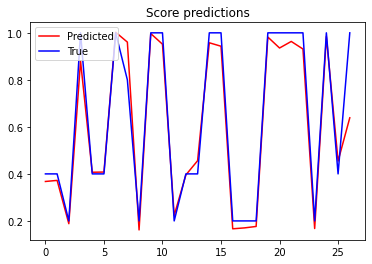

In [ ]:
plt.plot(predicted[:,0], '-r', label='Predicted')
plt.plot(test_labels[:,0], '-b', label='True')
plt.legend(loc="upper left")
plt.title('Score predictions')
plt.show()

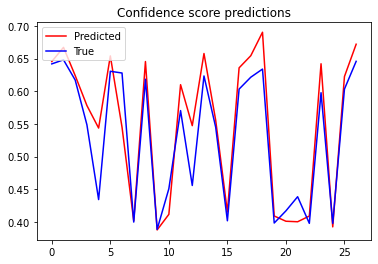

In [ ]:
plt.plot(predicted[:,1], '-r', label='Predicted')
plt.plot(test_labels[:,1], '-b', label='True')
plt.legend(loc="upper left")
plt.title('Confidence score predictions')
plt.show()